In [2]:
%matplotlib inline

import numpy as np

import matplotlib.image as mpimg

import matplotlib.pyplot as plt

import matplotlib.cm as cm

import png

import scipy.ndimage as ndimage

from scipy.misc import imsave, imshow

from scipy.ndimage import filters

import pyopencl as cl

import fed

In [3]:
# Our starting image
img = ndimage.imread('./eed-noise.png')
# extract red channel
img = img[:,:,0]
height, width = img.shape

In [4]:
def show(img, height=height, width=width):
    plt.imshow(img.reshape(height,width), cm.Greys_r, interpolation='none', vmin = 0, vmax = 255)

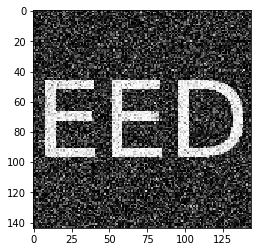

In [5]:
show(img)

<pyopencl.Context at 0x7fae3891fc80 on <pyopencl.Device 'Intel(R) Iris(TM) Graphics 6100' on 'Apple' at 0x1024500>>
110 iterations
stopping time 200.0
CPU times: user 96.7 ms, sys: 23.4 ms, total: 120 ms
Wall time: 131 ms


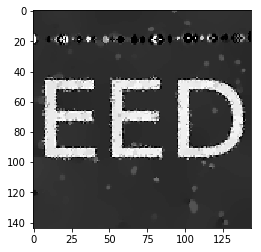

In [21]:
%%time
# nonlinear isotropic
def createBlurMask(sigma):
    maskSize = int(np.ceil(3.0*sigma))
    mask = np.zeros((maskSize*2+1, maskSize*2+1))
    
    maskSum = 0.0
    for a in xrange(-maskSize, maskSize+1):
        for b in xrange(-maskSize, maskSize+1):
            temp = np.exp(-( float(a*a + b*b) / (2*sigma*sigma) ))
            maskSum += temp
            mask[a+maskSize, b+maskSize] = temp
            
    # Normalize
    mask = mask / maskSum
    
    return mask, maskSize
  
mask, maskSize = createBlurMask(1.0)

platforms = cl.get_platforms()
ctx = cl.Context(
        dev_type=cl.device_type.GPU,
        properties=[(cl.context_properties.PLATFORM, platforms[0])])
print ctx
queue = cl.CommandQueue(ctx)

mf = cl.mem_flags


u_g = cl.Buffer(ctx, mf.READ_WRITE  | mf.COPY_HOST_PTR, hostbuf=img.astype(np.float32))
us_g = cl.Buffer(ctx, mf.READ_WRITE  | mf.COPY_HOST_PTR, hostbuf=img.astype(np.float32))
d_g = cl.Buffer(ctx, mf.READ_WRITE | mf.COPY_HOST_PTR, hostbuf=img.astype(np.float32))
mask_g = cl.Buffer(ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=mask.astype(np.float32))



prg = cl.Program(ctx, """
__constant float edge_threshold = 5.0; 
__constant float lsq = 25.0; //edge_threshold*edge_threshold;

inline float perona_malik_diffusivity(const float grad) {
    return 1.0/(1.0 + pown(grad/edge_threshold, 2));
}

inline int2 reflect(int2 i, const int h, const int w) {
  int2 ret = i;
  if (i.x < 0) {
    ret.x = abs(i.x);
  }
  if (i.x > w - 1) {
    ret.x = w - 1 - (i.x - (w - 1));
  }
  if (i.y < 0) {
    ret.y = abs(i.y);
  }
  if (i.y > h - 1) {
    ret.y = h - 1 - (i.y - (h - 1));
  }
  return ret;
}

inline float getpixel(const __global float * arr, const int2 pos, const int w) {
  return arr[pos.x + pos.y*w];
}

inline float gradmag_approx(const __global float * u,
                            const int2 pos,
                            const int h,
                            const int w) {
    const int2 left_i  = reflect(pos + (int2)(-1,  0), h, w);
    const int2 right_i = reflect(pos + (int2)( 1,  0), h, w);
    const int2 up_i    = reflect(pos + (int2)( 0, -1), h, w);
    const int2 down_i  = reflect(pos + (int2)( 0,  1), h, w);

    const float upc = getpixel(u, right_i, w);
    const float umc = getpixel(u, left_i, w);
    const float ucp = getpixel(u, down_i, w);
    const float ucm = getpixel(u, up_i, w);
    return pown((upc - umc)/2, 2) + pown((ucp - ucm)/2, 2);
}

__kernel void nonlinear_isotropic(__global float * u_g,
                                  __global float * us_g,
                                  const float dt)
{
    const int2 pos = {get_global_id(0), get_global_id(1)};
    const int width = get_global_size(0);
    const int height = get_global_size(1);

    // todo: use convolution to calculate image dx and dy like vispack does

    const int2 left_i  = reflect(pos + (int2)(-1,  0), height, width);
    const int2 right_i = reflect(pos + (int2)( 1,  0), height, width);
    const int2 up_i    = reflect(pos + (int2)( 0, -1), height, width);
    const int2 down_i  = reflect(pos + (int2)( 0,  1), height, width);

    const float ucc = getpixel(u_g, pos, width);
    const float upc = getpixel(u_g, right_i, width);
    const float umc = getpixel(u_g, left_i, width);
    const float ucp = getpixel(u_g, down_i, width);
    const float ucm = getpixel(u_g, up_i, width);

    const float graducc = gradmag_approx(us_g, pos, height, width);
    const float gradupc = gradmag_approx(us_g, right_i, height, width);
    const float gradumc = gradmag_approx(us_g, left_i, height, width);
    const float graducp = gradmag_approx(us_g, down_i, height, width);
    const float graducm = gradmag_approx(us_g, up_i, height, width);
    
    const float gcc = perona_malik_diffusivity(graducc);
    const float gpc = perona_malik_diffusivity(gradupc);
    const float gmc = perona_malik_diffusivity(gradumc);
    const float gcp = perona_malik_diffusivity(graducp);
    const float gcm = perona_malik_diffusivity(graducm);
    
    // midpixel diffusivities, phc = plus half, center = +1/2, 0
    const float gphc = (gpc+gcc)/2;
    const float gmhc = (gmc+gcc)/2;
    const float gcph = (gcp+gcc)/2;
    const float gcmh = (gcm+gcc)/2;
    
    const float d = (
                    gphc*upc +
                    gmhc*umc +
                    gcph*ucp +
                    gcmh*ucm -
                    (gphc+gmhc+gcph+gcmh) * ucc
                    );
    
    // since we're reading from us_g we don't need a barrier here
    u_g[pos.x + pos.y*width] += d * dt;
}

__kernel void gaussian_blur(__global float * img_g, __constant float * mask, __private const int maskSize,
                            __global float * blurred_img_g)
{
  const int posx = get_global_id(0);
  const int posy = get_global_id(1);
  const int width = get_global_size(0);
  const int height = get_global_size(1);
  
  float sum = 0.0f;
  
  for (int a = -maskSize; a < maskSize+1; a++) {
    for (int b = -maskSize; b < maskSize+1; b++) {
      const int imgpos = clamp(posx+a, 0, width) + clamp(posy+b, 0, height)*width;
      sum += mask[a+maskSize + (b+maskSize)*(maskSize*2+1)] * img_g[imgpos];
    }
  }
  
  blurred_img_g[posx+posy*get_global_size(0)] = sum;
}


""").build()

M = 5
T = 200.0
tau_max = 0.25
N, tau = fed.fed_tau_by_process_time(T, M, tau_max, True)

nli_step = prg.nonlinear_isotropic
nli_step.set_scalar_arg_dtypes( [None, None, np.float32] )

blur = prg.gaussian_blur
blur.set_scalar_arg_dtypes( [None, None, np.int32, None] )

stopping_time = 0
use_fed = 0
if use_fed == 0:
    print M*N, 'iterations'
    for m in xrange(M):
        blur(queue, img.shape, None, u_g, mask_g, maskSize, us_g)
        for dt in tau:
            #print 'Stepping %s in cycle %s' % (dt, m)
            #blur(queue, img.shape, None, u_g, mask_g, maskSize, us_g)
            nli_step(queue, img.shape, None, u_g, us_g, dt)
            stopping_time += dt
elif use_fed == 1:
    for _ in xrange(int(T/tau_max)):
        blur(queue, img.shape, None, u_g, mask_g, maskSize, us_g)
        nli_step(queue, img.shape, None, u_g, us_g, tau_max)
        stopping_time += tau_max
else:
    blur(queue, img.shape, None, u_g, mask_g, maskSize, us_g)

result_np = np.empty_like(img).astype(np.float32)
cl.enqueue_copy(queue, result_np, u_g)

# Show results
assert N == len(tau)
print 'stopping time', stopping_time
show(result_np)


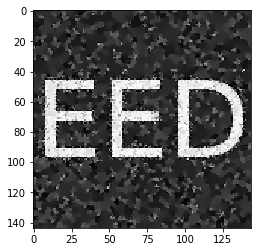

In [10]:
show(result_np)

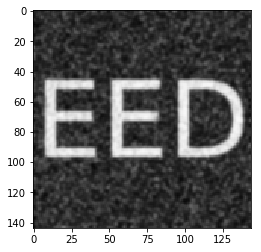

In [64]:
show(libblur)

In [2]:
M = 5
T = 200.0
dt = 0.25
N, tau = fed.fed_tau_by_process_time(T, M, dt, True)
print N, tau[0:10], 'speedup:', (T/dt)/(M*N)

17 [ 0.17594662  0.99258695  0.1247977   0.23457392  3.84376291  0.13548686
  0.35470921  0.15803631  0.65097318  0.12279619] speedup: 5.88235294118


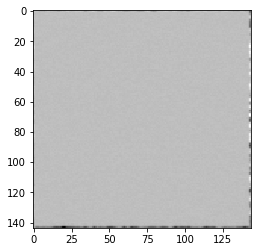

In [65]:
plt.imshow((A-B).reshape(height,width), cm.Greys_r, interpolation='none')